# **Loading Data**

## Installing and importing libraries

In [1]:
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install mordred

from IPython.display import clear_output
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import rdkit
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors
import warnings
warnings.filterwarnings('ignore')
clear_output()

## Select and retrieve bioactivity data for target

In [2]:
target_protein = new_client.target
protein_DF = pd.DataFrame.from_dict(target_protein.search('hdac2'))
protein_DF.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q92769', 'xref_name': None, 'xre...",Homo sapiens,Histone deacetylase 2,17.0,False,CHEMBL1937,"[{'accession': 'Q92769', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cereblon/Histone deacetylase 2,17.0,False,CHEMBL4296128,"[{'accession': 'Q92769', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
2,[],Homo sapiens,VHL/Histone deacetylase 2,15.0,False,CHEMBL4630743,"[{'accession': 'Q92769', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
3,[],Mus musculus,Cereblon/Histone deacetylase 2,15.0,False,CHEMBL4802026,"[{'accession': 'P70288', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,10090
4,[],Homo sapiens,Histone deacetylase (HDAC1 and HDAC2),14.0,False,CHEMBL2111429,"[{'accession': 'Q13547', 'component_descriptio...",PROTEIN FAMILY,9606


In [3]:
selected_target = protein_DF.target_chembl_id[0]
selected_target

'CHEMBL1937'

In [4]:
activity = new_client.activity
data = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

df = pd.DataFrame.from_dict(data)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,157538,[],CHEMBL697298,Inhibitory concentration against human Histone...,B,None,None,BAO_0000190,...,Homo sapiens,Histone deacetylase 2,9606,None,None,IC50,nM,UO_0000065,None,3300.0
1,None,None,167391,[],CHEMBL697298,Inhibitory concentration against human Histone...,B,None,None,BAO_0000190,...,Homo sapiens,Histone deacetylase 2,9606,None,None,IC50,nM,UO_0000065,None,47.0
2,None,None,180807,[],CHEMBL697298,Inhibitory concentration against human Histone...,B,None,None,BAO_0000190,...,Homo sapiens,Histone deacetylase 2,9606,None,None,IC50,nM,UO_0000065,None,3.9
3,None,None,1266083,[],CHEMBL697297,Inhibition of Histone deacetylase 2 (HDAC2) ac...,B,None,None,BAO_0000190,...,Homo sapiens,Histone deacetylase 2,9606,None,None,IC50,uM,UO_0000065,None,100.0
4,None,None,1266088,[],CHEMBL697297,Inhibition of Histone deacetylase 2 (HDAC2) ac...,B,None,None,BAO_0000190,...,Homo sapiens,Histone deacetylase 2,9606,None,None,IC50,uM,UO_0000065,None,100.0


# **Handling missing data**

In [5]:
df[['standard_value','canonical_smiles']].isna().sum()

,0
standard_value,107
canonical_smiles,3


In [6]:
df = df.dropna(subset=['standard_value','canonical_smiles'])
df['canonical_smiles'].nunique()

2434

In [7]:
df.duplicated(subset=['canonical_smiles']).sum()

635

In [8]:
df = df.drop_duplicates(['canonical_smiles'])
len(df)

2434

# **Data pre-processing**

## Combine the 3 columns (molecule_chembl_id, canonical_smiles, standard_value) and bioactivity_class into a DataFrame

In [9]:
df2 = df[['molecule_chembl_id','canonical_smiles','standard_value']]
df2.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,3300.0
1,CHEMBL343448,C/C=C1\NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H...,47.0
2,CHEMBL146250,C/C=C1\NC(=O)[C@@H](CS)NC(=O)[C@@H](C(C)C)NC(=...,3.9
3,CHEMBL138293,CC(=O)N(O)CCCCCC(=O)Nc1ccccc1,100000.0
4,CHEMBL138626,CC(=O)N(O)CCCCCCCC(=O)Nc1ccccc1,100000.0


In [10]:
print(df2.dtypes)

molecule_chembl_id    object
canonical_smiles      object
standard_value        object
dtype: object


In [11]:
df2['standard_value'] = df2['standard_value'].astype('float')
print(df2.dtypes)

molecule_chembl_id     object
canonical_smiles       object
standard_value        float64
dtype: object


## Determine Bioactivity

In [12]:
def determineBioactivity(num):
    if num >= 10000:
        return 'inactive'
    elif num <= 1000:
        return 'active'
    else:
        return 'intermediate'


df2['bioactivity_class'] = df2['standard_value'].apply(determineBioactivity)
print(len(df2))
df2.head()

2434


,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,3300.0,intermediate
1,CHEMBL343448,C/C=C1\NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H...,47.0,active
2,CHEMBL146250,C/C=C1\NC(=O)[C@@H](CS)NC(=O)[C@@H](C(C)C)NC(=...,3.9,active
3,CHEMBL138293,CC(=O)N(O)CCCCCC(=O)Nc1ccccc1,100000.0,inactive
4,CHEMBL138626,CC(=O)N(O)CCCCCCCC(=O)Nc1ccccc1,100000.0,inactive


## Calculate Lipinski descriptors

In [13]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        # Check if elem is a valid SMILES string before converting
        if isinstance(elem, str):
            mol=Chem.MolFromSmiles(elem)
            moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [14]:
df_lipinski = lipinski(df2.canonical_smiles)
print(len(df_lipinski))
df_lipinski.head()

2434


,MW,LogP,NumHDonors,NumHAcceptors
0,569.790,2.8512,3.0,8.0
1,540.708,1.4296,4.0,8.0
2,542.724,0.8942,6.0,8.0
3,264.325,2.4232,2.0,3.0
4,292.379,3.2034,2.0,3.0


In [15]:
df2.reset_index(drop=True, inplace=True)
df_lipinski.reset_index(drop=True, inplace=True)
df3 = pd.concat([df2, df_lipinski], axis=1)

print(len(df3))
df3.head()

2434


,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,3300.0,intermediate,569.790,2.8512,3.0,8.0
1,CHEMBL343448,C/C=C1\NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H...,47.0,active,540.708,1.4296,4.0,8.0
2,CHEMBL146250,C/C=C1\NC(=O)[C@@H](CS)NC(=O)[C@@H](C(C)C)NC(=...,3.9,active,542.724,0.8942,6.0,8.0
3,CHEMBL138293,CC(=O)N(O)CCCCCC(=O)Nc1ccccc1,100000.0,inactive,264.325,2.4232,2.0,3.0
4,CHEMBL138626,CC(=O)N(O)CCCCCCCC(=O)Nc1ccccc1,100000.0,inactive,292.379,3.2034,2.0,3.0


## Convert IC50 to pIC50

In [16]:
def IC50_to_pIC50(i):
    try:
        if i > 100_000_000:
            i = 100_000_000

        molar = i*(10**-9)
        return -np.log10(molar)

    except ValueError:
        return np.nan

df3['pIC50'] = df3['standard_value'].apply(IC50_to_pIC50)
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,3300.0,intermediate,569.790,2.8512,3.0,8.0,5.481486
1,CHEMBL343448,C/C=C1\NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H...,47.0,active,540.708,1.4296,4.0,8.0,7.327902
2,CHEMBL146250,C/C=C1\NC(=O)[C@@H](CS)NC(=O)[C@@H](C(C)C)NC(=...,3.9,active,542.724,0.8942,6.0,8.0,8.408935
3,CHEMBL138293,CC(=O)N(O)CCCCCC(=O)Nc1ccccc1,100000.0,inactive,264.325,2.4232,2.0,3.0,4.000000
4,CHEMBL138626,CC(=O)N(O)CCCCCCCC(=O)Nc1ccccc1,100000.0,inactive,292.379,3.2034,2.0,3.0,4.000000


In [17]:
df_final = df3.drop('standard_value', axis=1)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,intermediate,569.790,2.85120,3.0,8.0,5.481486
1,CHEMBL343448,C/C=C1\NC(=O)[C@H]2CSSCC/C=C/[C@H](CC(=O)N[C@H...,active,540.708,1.42960,4.0,8.0,7.327902
2,CHEMBL146250,C/C=C1\NC(=O)[C@@H](CS)NC(=O)[C@@H](C(C)C)NC(=...,active,542.724,0.89420,6.0,8.0,8.408935
3,CHEMBL138293,CC(=O)N(O)CCCCCC(=O)Nc1ccccc1,inactive,264.325,2.42320,2.0,3.0,4.000000
4,CHEMBL138626,CC(=O)N(O)CCCCCCCC(=O)Nc1ccccc1,inactive,292.379,3.20340,2.0,3.0,4.000000
...,...,...,...,...,...,...,...,...
2429,CHEMBL5274591,Cc1ccc(COc2cccc3ccc(C(=O)NCc4ccc(C(=O)NO)cc4)n...,active,441.487,4.17122,3.0,5.0,7.366532
2430,CHEMBL5267546,COc1ccc(COc2cccc3ccc(C(=O)NCc4ccc(C(=O)NO)cc4)...,active,457.486,3.87140,3.0,6.0,7.142668
2431,CHEMBL5280863,O=C(NO)c1ccc(CNC(=O)c2ccc3cccc(OCc4ccc(F)cc4)c...,active,445.450,4.00190,3.0,5.0,7.744727
2432,CHEMBL5270568,COc1cccc2ccc(C(=O)NCc3ccc(C(=O)NO)cc3)nc12,active,351.362,2.29240,3.0,5.0,7.585027


# **Exploratory Data Analysis**

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2434 non-null   object 
 1   canonical_smiles    2434 non-null   object 
 2   bioactivity_class   2434 non-null   object 
 3   MW                  2434 non-null   float64
 4   LogP                2434 non-null   float64
 5   NumHDonors          2434 non-null   float64
 6   NumHAcceptors       2434 non-null   float64
 7   pIC50               2434 non-null   float64
dtypes: float64(5), object(3)
memory usage: 152.2+ KB


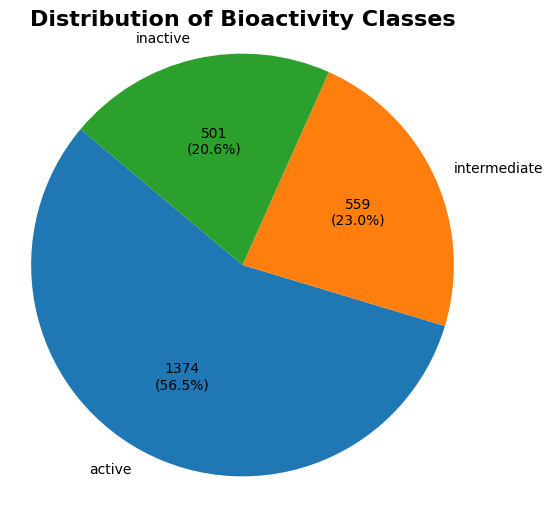

In [20]:
class_counts = df_final['bioactivity_class'].value_counts()

plt.figure(figsize=(6, 6))
wedge, texts, autotexts = plt.pie(class_counts, labels=class_counts.index,
                                  autopct='%1.1f%%', startangle=140)

for w, t, at in zip(wedge, texts, autotexts):
    at.set_text(f"{int(class_counts[t.get_text().split()[0]])}\n({at.get_text()})")

plt.title('Distribution of Bioactivity Classes', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

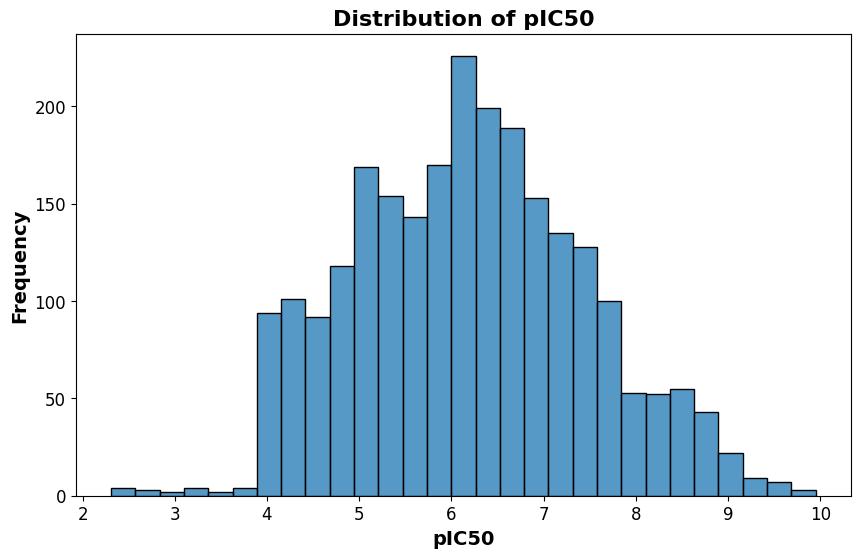

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['pIC50'])

plt.title('Distribution of pIC50', fontsize=16, fontweight='bold')
plt.xlabel('pIC50', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

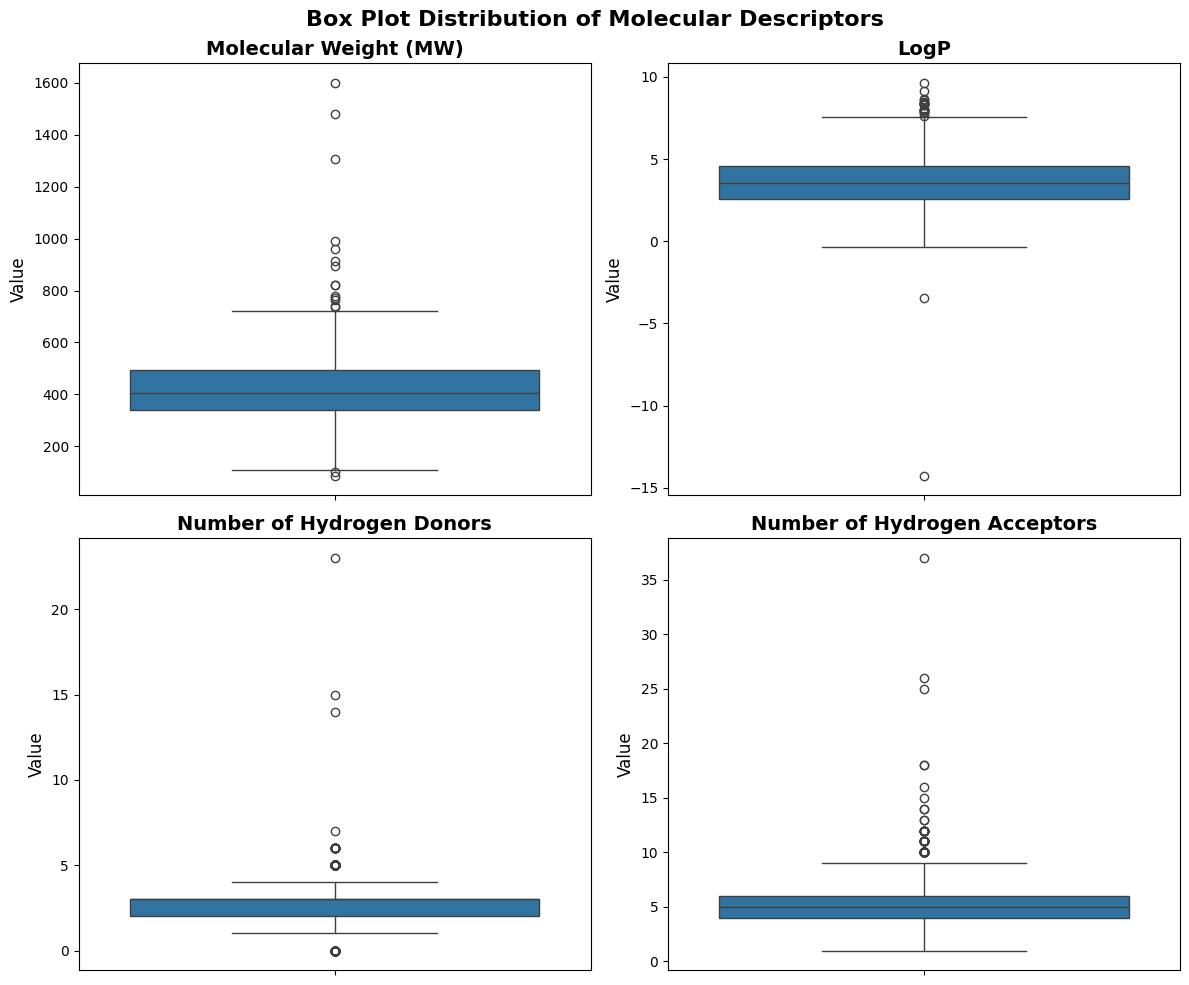

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Box plot for MW
sns.boxplot(ax=axs[0, 0], y=df_final['MW'])
axs[0, 0].set_title('Molecular Weight (MW)', fontsize=14, fontweight='bold')
axs[0, 0].set_ylabel('Value', fontsize=12)

# Box plot for LogP
sns.boxplot(ax=axs[0, 1], y=df_final['LogP'])
axs[0, 1].set_title('LogP', fontsize=14, fontweight='bold')
axs[0, 1].set_ylabel('Value', fontsize=12)

# Box plot for NumHDonors
sns.boxplot(ax=axs[1, 0], y=df_final['NumHDonors'])
axs[1, 0].set_title('Number of Hydrogen Donors', fontsize=14, fontweight='bold')
axs[1, 0].set_ylabel('Value', fontsize=12)

# Box plot for NumHAcceptors
sns.boxplot(ax=axs[1, 1], y=df_final['NumHAcceptors'])
axs[1, 1].set_title('Number of Hydrogen Acceptors', fontsize=14, fontweight='bold')
axs[1, 1].set_ylabel('Value', fontsize=12)

plt.suptitle('Box Plot Distribution of Molecular Descriptors',
             fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

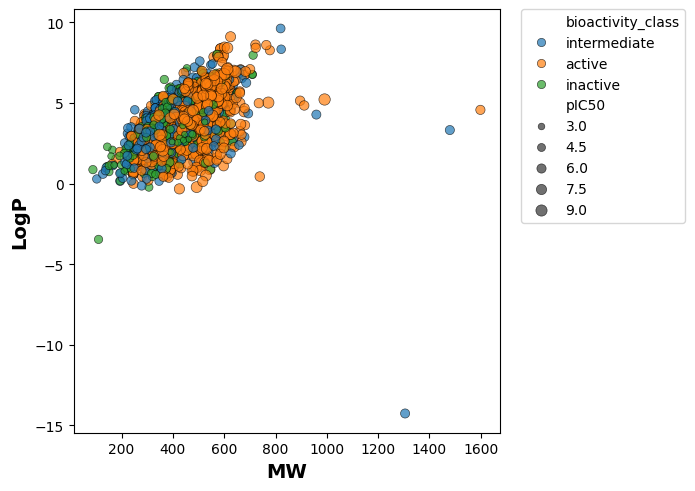

In [23]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class',
                size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

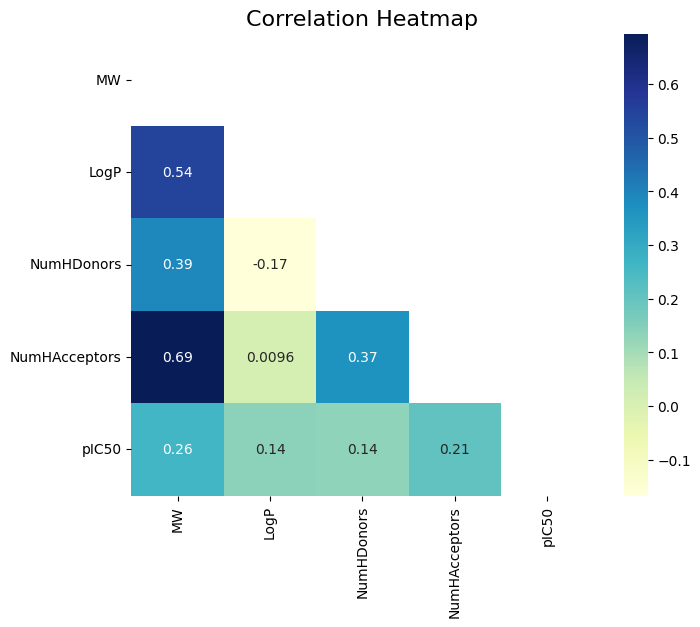

In [24]:
mask = np.triu(np.ones_like(df_final.corr(numeric_only=True), dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr(numeric_only=True), mask=mask, cmap="YlGnBu", annot=True, square=True)

plt.title("Correlation Heatmap", fontsize=16)

plt.show()

In [25]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

In [26]:
Mol_descriptors,desc_names = RDkit_descriptors(df_final["canonical_smiles"])

df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)

In [27]:
fp_pIC = pd.concat([df_final,df_with_200_descriptors], axis=1)
fp_pIC = fp_pIC.drop(['MW', 'canonical_smiles', 'molecule_chembl_id', 'bioactivity_class']
                     ,axis=1)

fp_pIC = fp_pIC.drop(index=[409,422,427,428,1795]) #rows with infinity values somehow
fp_pIC = fp_pIC.dropna()

fp_pIC.head()

,LogP,NumHDonors,NumHAcceptors,pIC50,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.8512,3.0,8.0,5.481486,15.041281,-6.173837,15.041281,1.097467,0.176093,569.790,...,2,0,0,0,0,0,0,0,0,0
1,1.4296,4.0,8.0,7.327902,14.792593,-5.714428,14.792593,1.035480,0.178339,540.708,...,0,0,0,0,0,0,0,0,0,0
2,0.8942,6.0,8.0,8.408935,14.706277,-5.798286,14.706277,0.938780,0.127429,542.724,...,0,0,0,0,0,0,0,0,0,0
3,2.4232,2.0,3.0,4.000000,12.887865,-4.560423,12.887865,0.670949,0.451204,264.325,...,0,0,0,0,0,0,0,0,0,0
4,3.2034,2.0,3.0,4.000000,13.036139,-4.811216,13.036139,0.736006,0.416972,292.379,...,0,0,0,0,0,0,0,0,0,0


# **Machine Learning**

## Splitting and scaling

In [28]:
from sklearn.model_selection import train_test_split

X = fp_pIC.drop(columns=['pIC50'])
y = fp_pIC['pIC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Determining the important features using tree models

In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_features = feature_importance_df.head(50)

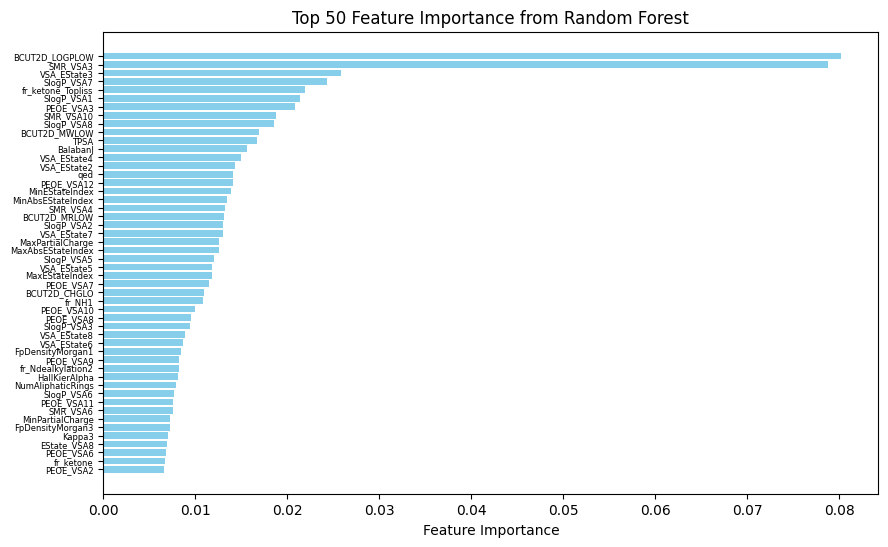

In [31]:
plt.figure(figsize=(10, 6))
plt.barh(top_50_features['Feature'], top_50_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.yticks(fontsize=6)
plt.title('Top 50 Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

## Cross Validate to find the best model

In [32]:
top_50_feature_indices = [X.columns.get_loc(feature) for feature in top_50_features['Feature']]

newX_train = X_train_scaled[:, top_50_feature_indices]
newX_test = X_test_scaled[:, top_50_feature_indices]

In [33]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score,mean_absolute_error

def calculateMetrics(model):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE
    r2_scorer = make_scorer(r2_score)  # R-squared
    mae_scorer = make_scorer(mean_absolute_error)  # MAE

    rmse_scores = cross_val_score(model, newX_train, y_train, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, newX_train, y_train, cv=kf, scoring=r2_scorer)
    mae_scores = cross_val_score(model, newX_train, y_train, cv=kf, scoring=mae_scorer)

    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    mean_mae = np.mean(mae_scores)

    return mean_rmse, mean_r2, mean_mae

In [34]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'XGBoost': xgb.XGBRegressor(eval_metric='rmse'),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

for model_name, model in models.items():
    mean_rmse, mean_r2, mean_mae = calculateMetrics(model)
    results.append({'Model': model_name, 'Mean RMSE': mean_rmse, 'Mean R²': mean_r2, 'Mean MAE':mean_mae})

results_df = pd.DataFrame(results)
results_df.head(6)

,Model,Mean RMSE,Mean R²,Mean MAE
0,Linear Regression,1.034869,0.343264,0.830269
1,Ridge Regression,1.034558,0.343652,0.830404
2,Random Forest,0.777422,0.630723,0.588290
3,K-Neighbors Regressor,0.858409,0.545685,0.645880
4,XGBoost,0.801711,0.605304,0.597267
5,Decision Tree,1.076791,0.284148,0.752557


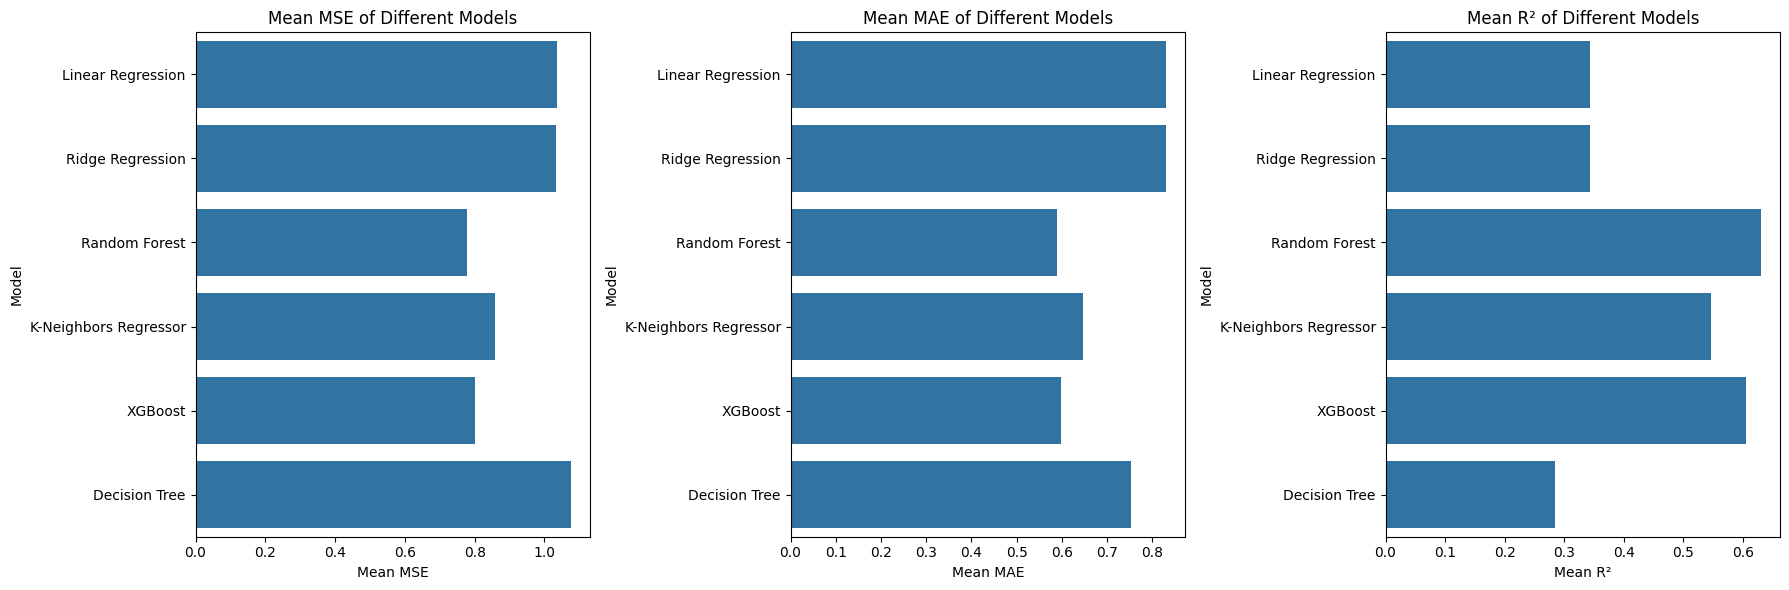

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot RMSE
sns.barplot(x='Mean RMSE', y='Model', data=results_df, ax=ax[0])
ax[0].set_title('Mean MSE of Different Models')
ax[0].set_xlabel('Mean MSE')
ax[0].set_ylabel('Model')

# Plot MAE
sns.barplot(x='Mean MAE', y='Model', data=results_df, ax=ax[1])
ax[1].set_title('Mean MAE of Different Models')
ax[1].set_xlabel('Mean MAE')
ax[1].set_ylabel('Model')

# Plot R² scores
sns.barplot(x='Mean R²', y='Model', data=results_df, ax=ax[2])
ax[2].set_title('Mean R² of Different Models')
ax[2].set_xlabel('Mean R²')
ax[2].set_ylabel('Model')

# Adjust layout
plt.tight_layout()
plt.show()